In [0]:
import pre
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
corpus=pre.create_sentence_list(1)
from nltk.stem import SnowballStemmer
from collections import Counter
from sklearn.model_selection import GridSearchCV
fileid=pre.fileid
sentences=pre.create_sentence_list(1)
label=pre.create_label(1)
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import train_test as split

In [0]:
new_label=[]
new_sentences=[]
new_fileid=[]
length = label
for i in range(0, len(sentences)):
  for j in range(0,len(label[i])):
    new_sentences.append(sentences[i])
    new_label.append(label[i][j])
    new_fileid.append(fileid[i])
data_items=list(zip(new_sentences,new_label))
df=pre.pd.DataFrame(data_items,columns=['narrative','Product'])
print(df)
print(Counter(new_label))

                                               narrative Product
0      in this paper the authors present an adaptatio...    NULL
1      the authors go on to compare their baseline-co...     CMP
2                      overall the results are a bit mix     EMP
3      the bc method often performs similarly to or i...     NOV
4      the bc method often performs similarly to or i...     CMP
...                                                  ...     ...
14928  it may also be interesting to provide suitable...     EMP
14929  the interesting paper provides theoretical sup...     EMP
14930  the paper also provides numerical results to s...     EMP
14931              the paper is well presented and organ     PNF
14932  -in theorem  the embedding dimension $d$ is de...     EMP

[14933 rows x 2 columns]
Counter({'EMP': 6191, 'NULL': 3079, 'CMP': 1262, 'SUB': 1192, 'CLA': 854, 'IMP': 692, 'PNF': 657, 'NOV': 530, 'REC': 212, 'CNT': 154, 'APR': 110})


In [0]:
print("Percentage of labels")
#size=len(df['Product'])
size=len(sentences)
c = Counter(new_label)
per={}
keys=c.keys()
for key in keys:
  per[key]=round(((c[key]/size) * 100.0),2)
print(per)


Percentage of labels
{'NULL': 22.76, 'CMP': 9.33, 'EMP': 45.75, 'NOV': 3.92, 'CLA': 6.31, 'SUB': 8.81, 'REC': 1.57, 'PNF': 4.86, 'IMP': 5.11, 'CNT': 1.14, 'APR': 0.81}


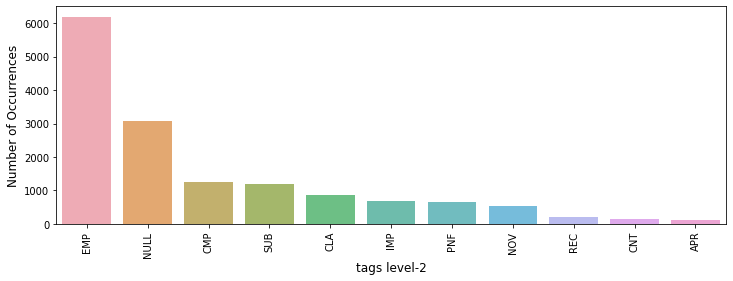

In [0]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('tags level-2', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [0]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['narrative'] = df['narrative'].apply(cleanText)

In [0]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [0]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [0]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [0]:
train_tagged.values[30]


TaggedDocument(words=['do', 'agree', 'now', 'on', 'figure', 'which', 'tips', 'the', 'scale', 'for', 'me', 'to', 'weak', 'accept'], tags=['NULL'])

In [0]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 10453/10453 [00:00<00:00, 1284928.92it/s]


In [0]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=20)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 10453/10453 [00:00<00:00, 1710948.67it/s]


CPU times: user 10min 21s, sys: 1min 3s, total: 11min 25s
Wall time: 6min 44s


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
y_tr, X_tr = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [0]:
y_tr=list(y_tr)

In [0]:
from sklearn import preprocessing
X_tr = preprocessing.scale(X_tr)
X_test = preprocessing.scale(X_test)


In [0]:
keys_level1=['INT', 'PDI', 'MET', 'RWK', 'DAT', 'RES', 'ANA', 'TNF', 'EXP', 'BIB', 'OAL', 'FWK', 'EXT', 'ABS', 'CNT']
keys_level2=['NULL', 'CMP', 'EMP', 'NOV', 'CLA', 'SUB', 'IMP', 'REC', 'CNT', 'PNF', 'APR']

freq_train=Counter(y_tr)
print(freq_train)
c=0
def increase(keys, freq, sen,tag,threshold):
  length=len(sen)
  for key in keys:
    
    if (freq[key] < threshold and freq[key] > 0):
      inc= int(threshold/ freq[key])
      for i in range(0,length):
        if (tag[i] == key):
          for j in range(0,inc):
            tag.append(tag[i])
            sen= np.append(sen, [sen[i]], axis=0)
            global c
            c=c+1
    global X_train
    X_train = sen
    global y_train
    y_train = tag

increase(keys_level2, freq_train, X_tr, y_tr,1500)
print(Counter(y_train))

Counter({'EMP': 4276, 'NULL': 2169, 'CMP': 898, 'SUB': 879, 'CLA': 590, 'IMP': 479, 'PNF': 470, 'NOV': 369, 'REC': 139, 'CNT': 106, 'APR': 78})
Counter({'EMP': 4276, 'NULL': 2169, 'IMP': 1916, 'PNF': 1880, 'NOV': 1845, 'CMP': 1796, 'CLA': 1770, 'SUB': 1758, 'CNT': 1590, 'APR': 1560, 'REC': 1529})


In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.2328125
Testing F1 score: 0.22875326499550452


DMM


In [0]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 10453/10453 [00:00<00:00, 1158275.91it/s]


In [0]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=20)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 10453/10453 [00:00<00:00, 2595492.52it/s]


CPU times: user 20min 44s, sys: 4min 54s, total: 25min 39s
Wall time: 17min 42s


LOGISTIC


In [0]:

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
from sklearn.metrics import classification_report
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred))

Testing accuracy 0.3669642857142857
Testing F1 score: 0.29328522570669363
              precision    recall  f1-score   support

         APR       0.00      0.00      0.00        32
         CLA       0.04      0.02      0.03       264
         CMP       0.11      0.02      0.03       364
         CNT       0.00      0.00      0.00        48
         EMP       0.43      0.72      0.53      1915
         IMP       0.00      0.00      0.00       213
         NOV       0.22      0.08      0.12       161
        NULL       0.26      0.26      0.26       910
         PNF       0.06      0.01      0.02       187
         REC       0.00      0.00      0.00        73
         SUB       0.08      0.02      0.03       313

    accuracy                           0.37      4480
   macro avg       0.11      0.10      0.09      4480
weighted avg       0.26      0.37      0.29      4480



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
clf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt',class_weight='balanced_subsample')

import sklearn.metrics as metrics
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,zero_division=1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         APR       1.00      0.00      0.00        32
         CLA       1.00      0.00      0.00       264
         CMP       1.00      0.00      0.00       364
         CNT       1.00      0.00      0.00        48
         EMP       0.43      0.99      0.60      1915
         IMP       1.00      0.00      0.00       213
         NOV       0.83      0.03      0.06       161
        NULL       0.26      0.01      0.03       910
         PNF       1.00      0.00      0.00       187
         REC       1.00      0.00      0.00        73
         SUB       1.00      0.00      0.00       313

    accuracy                           0.43      4480
   macro avg       0.87      0.09      0.06      4480
weighted avg       0.60      0.43      0.26      4480

Accuracy: 0.4263392857142857


SVM

In [0]:
from sklearn import svm
from sklearn.model_selection import train_test_split
# Make a decision tree and train
clf = svm.SVC(class_weight='balanced',decision_function_shape='ovo')
import sklearn.metrics as metrics
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,zero_division=1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         APR       0.04      0.03      0.04        32
         CLA       0.12      0.22      0.16       264
         CMP       0.10      0.44      0.16       364
         CNT       0.05      0.12      0.07        48
         EMP       0.44      0.18      0.26      1915
         IMP       0.07      0.06      0.06       213
         NOV       0.08      0.11      0.09       161
        NULL       0.28      0.13      0.17       910
         PNF       0.06      0.08      0.07       187
         REC       0.03      0.03      0.03        73
         SUB       0.08      0.07      0.08       313

    accuracy                           0.17      4480
   macro avg       0.12      0.13      0.11      4480
weighted avg       0.28      0.17      0.18      4480

Accuracy: 0.16763392857142856


SGD

In [0]:

from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,zero_division=1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         APR       0.00      0.00      0.00        32
         CLA       0.10      0.01      0.02       264
         CMP       0.08      0.01      0.01       364
         CNT       0.00      0.00      0.00        48
         EMP       0.43      0.84      0.57      1915
         IMP       0.00      0.00      0.00       213
         NOV       0.14      0.09      0.11       161
        NULL       0.26      0.12      0.17       910
         PNF       0.07      0.01      0.02       187
         REC       0.00      0.00      0.00        73
         SUB       0.00      0.00      0.00       313

    accuracy                           0.39      4480
   macro avg       0.10      0.10      0.08      4480
weighted avg       0.26      0.39      0.28      4480

Accuracy: 0.390625


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


DECISION TREE

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,zero_division=1))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         APR       0.02      0.03      0.02        32
         CLA       0.06      0.06      0.06       264
         CMP       0.08      0.09      0.08       364
         CNT       0.00      0.00      0.00        48
         EMP       0.41      0.31      0.35      1915
         IMP       0.05      0.07      0.06       213
         NOV       0.05      0.06      0.06       161
        NULL       0.21      0.23      0.22       910
         PNF       0.06      0.07      0.06       187
         REC       0.01      0.01      0.01        73
         SUB       0.06      0.08      0.07       313

    accuracy                           0.20      4480
   macro avg       0.09      0.09      0.09      4480
weighted avg       0.24      0.20      0.22      4480

Accuracy: 0.20245535714285715


In [0]:

model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [0]:
!pip install testfixtures
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [0]:

def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [0]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


Testing accuracy 0.21272321428571428
Testing F1 score: 0.22302649142800077


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         APR       0.00      0.00      0.00        32
         CLA       0.07      0.08      0.07       264
         CMP       0.08      0.09      0.08       364
         CNT       0.00      0.00      0.00        48
         EMP       0.41      0.34      0.37      1915
         IMP       0.03      0.03      0.03       213
         NOV       0.04      0.05      0.04       161
        NULL       0.20      0.22      0.21       910
         PNF       0.04      0.04      0.04       187
         REC       0.00      0.00      0.00        73
         SUB       0.08      0.10      0.09       313

    accuracy                           0.21      4480
   macro avg       0.09      0.09      0.09      4480
weighted avg       0.24      0.21      0.22      4480

